## 🚀 Initialization

In [1]:
import numpy as np
import pandas as pd
from mlfluids import Fluid, set_refprop_path

set_refprop_path("/home/braun/Documents/Developer/REFPROP10")

## ⚙️ Parameters

In [2]:
MIXTURE = "CO2&H2S"

PHASE = "supercritical"
PROPS = ["P*", "T*", "VIS*", "TCX*"]

In [3]:
fluid = Fluid(MIXTURE)

Xpoints = 5

Tmin = 1.1
Tmax = 5.0
Tpoints = 5

Pmin = 1.1
Pmax = 10.0
Ppoints = 5

## 🧪 Data preparation

In [4]:
X = np.linspace(0, 1, Xpoints + 1, endpoint=False)[1:]

Pr = np.geomspace(Pmin, Pmax, Ppoints)
Tr = np.geomspace(Tmin, Tmax, Tpoints)

PrTr = np.stack(np.meshgrid(Pr, Tr, indexing="ij"), axis=-1).reshape(-1, 2)

In [5]:
norm_fluid = Fluid(MIXTURE)


def calc_props_X(Xv: float) -> pd.DataFrame:
    # SETUP: NORMALIZING FLUID
    norm_fluid.set_mole_fractions([Xv, 1 - Xv])
    norm_fluid.set_state_critical()
    Fluid.set_normalizing_fluid(norm_fluid)

    # SETUP: FLUID
    fluid.set_mole_fractions([Xv, 1 - Xv])
    fluid._D = norm_fluid.rhomolar_critical()
    if PHASE:
        fluid.specify_phase(PHASE)

    # PARAMETER CALCULATION
    props_data = fluid.calc_states_props("P*", "T*", PrTr, PROPS, log_errors=False)

    return pd.DataFrame(props_data, columns=PROPS)


data = pd.concat([calc_props_X(Xv) for Xv in X], ignore_index=True)

In [6]:
display(data)

,P*,T*,VIS*,TCX*
0,1.100000,1.100000,0.610580,0.427911
1,1.100000,1.606153,0.769647,0.491798
2,1.100000,2.345208,1.069969,0.742089
3,1.100000,3.424331,1.480506,1.093669
4,1.100000,5.000000,2.021505,1.427912
...,...,...,...,...
115,5.759014,5.000000,1.816000,1.278934
116,10.000000,1.606153,1.927422,0.885507
117,10.000000,2.345208,1.500354,0.803518
118,10.000000,3.424331,1.575452,0.966583


## 🤖 Model Training

In [7]:
import pycaret.regression as reg

reg = reg.setup(
    data=data,
    target="VIS*",
    numeric_features=["T*", "P*"],
    ignore_features=["TCX*"],
    session_id=123,
    verbose=False,
)
best = reg.compare_models(round=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0383002998,0.0039643256,0.0515606550,0.9844640240,0.0207806424,0.0268624873,0.0300000000
gbr,Gradient Boosting Regressor,0.0426729833,0.0034066977,0.0543769749,0.9818044735,0.0222299311,0.0319599226,0.0160000000
dt,Decision Tree Regressor,0.0415109180,0.0071571454,0.0599677552,0.9759371385,0.0258923695,0.0294315120,0.0060000000
rf,Random Forest Regressor,0.0508064759,0.0076232392,0.0737702852,0.9663113018,0.0336048774,0.0425243320,0.0410000000
ada,AdaBoost Regressor,0.0899167972,0.0159908422,0.1221195068,0.9135480238,0.0566247359,0.0766944749,0.0280000000
knn,K Neighbors Regressor,0.1921196334,0.0839949736,0.2654879235,0.4149041382,0.1014313478,0.1340884041,0.0080000000
lightgbm,Light Gradient Boosting Machine,0.2930248540,0.1358226358,0.3609918706,0.1863098465,0.1438793682,0.2221287663,7.8690000000
ridge,Ridge Regression,0.3168113098,0.1722231075,0.3998223692,0.0713912735,0.1603339754,0.2362129480,0.0070000000
lr,Linear Regression,0.3166895047,0.1722651690,0.3997930080,0.0712495577,0.1602981068,0.2359978884,0.2560000000
lar,Least Angle Regression,0.3166895345,0.1722651869,0.3997930318,0.0712493630,0.1602981128,0.2359979168,0.0060000000


## 📈 Analysis

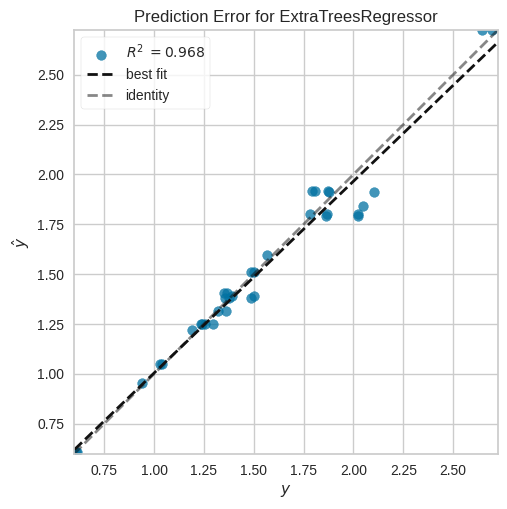

In [8]:
reg.plot_model(best, plot="error")

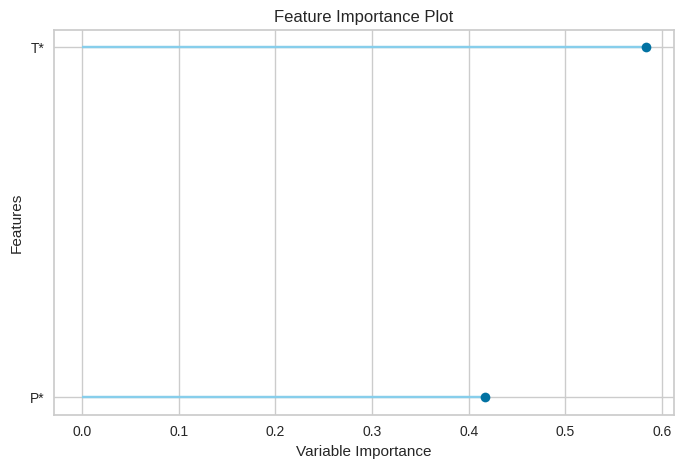

In [9]:
reg.plot_model(best, plot="feature")